# Model Errors

In this notebook we compare different versions of the Heston MC model, and calculate model errors vs closed form solution.

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
from finmc.calc.option import opt_price_mc

from src.models.aes import HestonAESMC
from src.models.basic import HestonMCBasic
from src.models.better import HestonMCBetter, HestonMCMilstein
from src.models.closed import price_vanilla_call

## Create Dataset
Create the dataset, with MC params, discounts and fwds as required by the [Dataset API](https://qablet-academy.github.io/intro/dataset/)

In [ ]:
# Rate Curve
times = np.array([0.0, 5.0])
rates = np.array([0.0, 0.0])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

# Forward Curve
ticker = "EQ"
spot = 100.0
div_rate = 0.0
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

pricing_datetime = datetime(2023, 12, 31)
dataset = {
    "BASE": "USD",
    "ASSETS": {"USD": discount_data, ticker: fwd_data},
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 100,
        "SEED": 1,
    },
    "HESTON": {
        "ASSET": ticker,
        "INITIAL_VAR": 0.04,
        "LONG_VAR": 0.04,
        "VOL_OF_VOL": 0.8,
        "MEANREV": 1.0,
        "CORRELATION": -0.9,
    },
}

## Calculate Single Option Prices

Define a [Vanilla Option](https://qablet.github.io/qablet-contracts/examples/equity_vanilla/) and calculate price.

In [ ]:
# Contract Terms
strike = 100
maturity = 1.0

In [ ]:
# Closed form price
ref_price, _ = price_vanilla_call(
    strike,
    maturity,
    ticker,
    dataset,
)
print(f"ref_price: {ref_price:11.6f}")

ref_price:    5.553861


In [ ]:
# Create four different models, calculate price, and error
models = {
    "Basic": HestonMCBasic,
    "AES": HestonAESMC,
    "Better": HestonMCBetter,  # Uses Log Euler for spot, antithetic paths
    "Milstein": HestonMCMilstein,  # better + milstein discretization for vol
}

for model_name, model_cls in models.items():
    model = model_cls(dataset)
    price = opt_price_mc(strike, maturity, "Call", ticker, model)
    print(f"{model_name:20s}: {price:11.6f} {price - ref_price:+11.6f}")

Basic               :    5.660415   +0.106554
AES                 :    5.536037   -0.017824
Better              :    5.633567   +0.079706
Milstein            :    5.660967   +0.107106


## Compare distribution of spot and variance

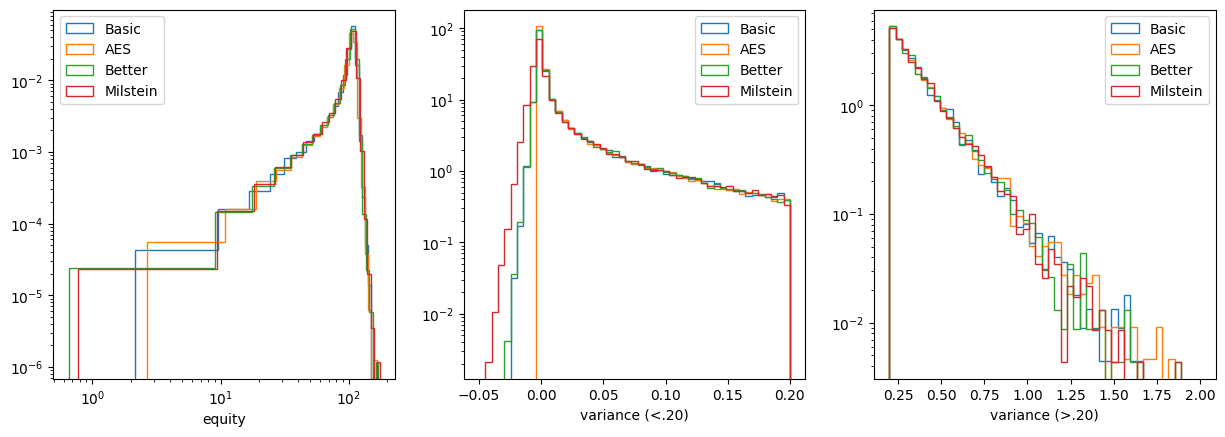

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)

for model_name, model_cls in models.items():
    model = model_cls(dataset)
    model.reset()
    model.advance(maturity)
    eq_vals = model.get_value(ticker)
    var_vals = model.get_value("variance")

    ax1.hist(
        eq_vals,
        bins=20,
        histtype="step",
        label=model_name,
        density=True,
    )
    ax1.set_xlabel("equity")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.legend()

    ax2.hist(
        var_vals,
        bins=np.linspace(-0.05, 0.20, 50),
        histtype="step",
        label=model_name,
        density=True,
    )
    ax2.set_xlabel("variance (<.20)")
    ax2.set_yscale("log")
    ax2.legend()

    ax3.hist(
        var_vals,
        bins=np.linspace(0.20, 2.0, 50),
        histtype="step",
        label=model_name,
        density=True,
    )
    ax3.set_xlabel("variance (>.20)")
    ax3.set_yscale("log")
    ax3.legend()